# House Buying Classification: Base Models vs Bootstrap Ensemble

This notebook compares three neural networks and three non-neural models on the house-buying dataset.

- **Target**: `can_buy` with classes `no`, `neutral`, `yes`
- **Methods**: NN (small/medium/deep), KNN, KMeans++, K-Medoids
- **Ensemble**: bootstrap bagging with CV-weighted soft voting
- **Evaluation**: accuracy, macro precision/recall/F1, balanced accuracy, log loss, ROC-AUC, confusion matrices, ROC curves


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Helps avoid MKL KMeans warnings on Windows

from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

sns.set_theme(style="whitegrid")
np.random.seed(42)


In [2]:
PROJECT_DIR = Path.cwd()
if not (PROJECT_DIR / "csv").exists():
    PROJECT_DIR = PROJECT_DIR.parent

DATA_DIR = PROJECT_DIR / "csv"

train_df = pd.read_csv(DATA_DIR / "house_buy_train.csv")
cv_df = pd.read_csv(DATA_DIR / "house_buy_cv.csv")
test_df = pd.read_csv(DATA_DIR / "house_buy_test.csv")

feature_cols = [
    "buyer_income_lpa",
    "house_price_lakh",
    "loan_eligibility",
    "credit_score",
    "down_payment_percent",
    "existing_emi_lpa",
    "employment_years",
    "dependents",
    "property_location_score",
    "employment_type",
]

numeric_cols = [
    "buyer_income_lpa",
    "house_price_lakh",
    "credit_score",
    "down_payment_percent",
    "existing_emi_lpa",
    "employment_years",
    "dependents",
    "property_location_score",
]

cat_cols = ["loan_eligibility", "employment_type"]

label_to_int = {"no": 0, "neutral": 1, "yes": 2}
int_to_label = {v: k for k, v in label_to_int.items()}
class_order = np.array([0, 1, 2])
class_names = [int_to_label[i] for i in class_order]

X_train_raw = train_df[feature_cols]
y_train = train_df["can_buy"].map(label_to_int).to_numpy()
X_cv_raw = cv_df[feature_cols]
y_cv = cv_df["can_buy"].map(label_to_int).to_numpy()
X_test_raw = test_df[feature_cols]
y_test = test_df["can_buy"].map(label_to_int).to_numpy()

print("Train shape:", train_df.shape)
print("CV shape:", cv_df.shape)
print("Test shape:", test_df.shape)
print("Class distribution (train):", train_df["can_buy"].value_counts().to_dict())


Train shape: (3000, 11)
CV shape: (400, 11)
Test shape: (300, 11)
Class distribution (train): {'no': 1000, 'yes': 1000, 'neutral': 1000}


In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train = preprocessor.fit_transform(X_train_raw)
X_cv = preprocessor.transform(X_cv_raw)
X_test = preprocessor.transform(X_test_raw)

# Convert to dense arrays so every model (including custom clustering models) can consume the same inputs.
X_train = X_train.toarray() if hasattr(X_train, "toarray") else np.asarray(X_train)
X_cv = X_cv.toarray() if hasattr(X_cv, "toarray") else np.asarray(X_cv)
X_test = X_test.toarray() if hasattr(X_test, "toarray") else np.asarray(X_test)

print("Processed feature count:", X_train.shape[1])


Processed feature count: 13


## Custom label-aware clustering models

In [4]:
class KMeansLabelModel:
    def __init__(self, n_clusters=7, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y, n_classes=3):
        self.model = KMeans(
            n_clusters=self.n_clusters,
            init="k-means++",
            n_init=20,
            random_state=self.random_state,
        )
        cluster_ids = self.model.fit_predict(X)
        self.classes_ = np.arange(n_classes)
        self.cluster_proba_ = np.zeros((self.n_clusters, n_classes), dtype=float)

        for c in range(self.n_clusters):
            idx = np.where(cluster_ids == c)[0]
            if len(idx) == 0:
                self.cluster_proba_[c] = np.ones(n_classes) / n_classes
            else:
                counts = np.bincount(y[idx], minlength=n_classes).astype(float)
                self.cluster_proba_[c] = (counts + 1.0) / (counts.sum() + n_classes)
        return self

    def predict_proba(self, X):
        nearest_cluster = self.model.predict(X)
        return self.cluster_proba_[nearest_cluster]

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)


class KMedoidsLabelModel:
    def __init__(self, n_clusters=7, random_state=42, max_iter=30):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter

    def fit(self, X, y, n_classes=3):
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        k = min(self.n_clusters, n_samples)

        medoid_idx = rng.choice(n_samples, size=k, replace=False)

        for _ in range(self.max_iter):
            d2 = ((X[:, None, :] - X[medoid_idx][None, :, :]) ** 2).sum(axis=2)
            assignments = d2.argmin(axis=1)

            changed = False
            new_medoid_idx = medoid_idx.copy()

            for c in range(k):
                pts = np.where(assignments == c)[0]
                if len(pts) == 0:
                    continue
                cluster_pts = X[pts]
                within_cluster_d2 = ((cluster_pts[:, None, :] - cluster_pts[None, :, :]) ** 2).sum(axis=2)
                best_local_pt = pts[within_cluster_d2.sum(axis=1).argmin()]
                if best_local_pt != medoid_idx[c]:
                    changed = True
                    new_medoid_idx[c] = best_local_pt

            medoid_idx = new_medoid_idx
            if not changed:
                break

        self.medoids_ = X[medoid_idx]
        self.classes_ = np.arange(n_classes)

        d2_final = ((X[:, None, :] - self.medoids_[None, :, :]) ** 2).sum(axis=2)
        assignments = d2_final.argmin(axis=1)

        self.cluster_proba_ = np.zeros((k, n_classes), dtype=float)
        for c in range(k):
            idx = np.where(assignments == c)[0]
            if len(idx) == 0:
                self.cluster_proba_[c] = np.ones(n_classes) / n_classes
            else:
                counts = np.bincount(y[idx], minlength=n_classes).astype(float)
                self.cluster_proba_[c] = (counts + 1.0) / (counts.sum() + n_classes)
        return self

    def predict_proba(self, X):
        d2 = ((X[:, None, :] - self.medoids_[None, :, :]) ** 2).sum(axis=2)
        nearest_medoid = d2.argmin(axis=1)
        return self.cluster_proba_[nearest_medoid]

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)


class SeedAveragedMLP:
    def __init__(self, base_params, seeds):
        self.base_params = dict(base_params)
        self.seeds = list(seeds)
        self.models = []
        self.classes_ = np.array([0, 1, 2])

    def fit(self, X, y):
        self.models = []
        for seed in self.seeds:
            model = MLPClassifier(random_state=seed, **self.base_params)
            model.fit(X, y)
            self.models.append(model)
        return self

    def predict_proba(self, X):
        if not self.models:
            raise RuntimeError("SeedAveragedMLP must be fitted before prediction.")

        n_classes = len(self.classes_)
        avg = np.zeros((X.shape[0], n_classes), dtype=float)
        for model in self.models:
            proba = model.predict_proba(X)
            aligned = np.zeros((X.shape[0], n_classes), dtype=float)
            for col_idx, cls in enumerate(model.classes_):
                aligned[:, int(cls)] = proba[:, col_idx]
            avg += aligned
        return avg / len(self.models)


## Training + metric helpers

In [5]:
def build_base_models(seed):
    return {
        "nn_small": SeedAveragedMLP(
            base_params={
                "hidden_layer_sizes": (24,),
                "activation": "relu",
                "solver": "adam",
                "alpha": 0.01,
                "learning_rate_init": 0.0012,
                "max_iter": 2200,
                "early_stopping": True,
                "validation_fraction": 0.2,
                "n_iter_no_change": 25,
            },
            seeds=[seed + 1, seed + 11, seed + 21, seed + 31, seed + 41],
        ),
        "nn_medium": MLPClassifier(
            hidden_layer_sizes=(44, 22),
            activation="relu",
            solver="adam",
            alpha=0.02,
            learning_rate_init=0.0007,
            max_iter=2600,
            early_stopping=True,
            validation_fraction=0.22,
            n_iter_no_change=20,
            random_state=seed + 3,
        ),
        "nn_deep": MLPClassifier(
            hidden_layer_sizes=(56, 28, 14),
            activation="relu",
            solver="adam",
            alpha=0.012,
            learning_rate_init=0.001,
            max_iter=2800,
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=25,
            random_state=seed + 4,
        ),
        "knn": KNeighborsClassifier(n_neighbors=11, weights="distance"),
        "kmeanspp": KMeansLabelModel(n_clusters=9, random_state=seed + 5),
        "kmedoids": KMedoidsLabelModel(n_clusters=9, random_state=seed + 6, max_iter=35),
    }


def fit_model(model, X, y, n_classes):
    if isinstance(model, (KMeansLabelModel, KMedoidsLabelModel)):
        model.fit(X, y, n_classes=n_classes)
    else:
        model.fit(X, y)
    return model


def predict_proba_full(model, X, n_classes):
    proba = model.predict_proba(X)

    if proba.shape[1] == n_classes:
        return proba

    full = np.zeros((proba.shape[0], n_classes), dtype=float)
    if hasattr(model, "classes_"):
        for col_idx, cls in enumerate(model.classes_):
            full[:, int(cls)] = proba[:, col_idx]
    else:
        full[:, : proba.shape[1]] = proba
    row_sum = full.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    return full / row_sum


def evaluate_split(y_true, y_pred, y_proba, n_classes):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[0],
        "recall_macro": precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[1],
        "f1_macro": precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[2],
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    }

    labels = np.arange(n_classes)
    y_true_bin = label_binarize(y_true, classes=labels)

    try:
        metrics["log_loss"] = log_loss(y_true, y_proba, labels=labels)
    except Exception:
        metrics["log_loss"] = np.nan

    try:
        metrics["roc_auc_macro_ovr"] = roc_auc_score(y_true_bin, y_proba, average="macro", multi_class="ovr")
    except Exception:
        metrics["roc_auc_macro_ovr"] = np.nan

    return metrics


def evaluate_model_on_splits(model, splits, n_classes):
    pred_store = {}
    proba_store = {}
    rows = []

    for split_name, (X_split, y_split) in splits.items():
        split_proba = predict_proba_full(model, X_split, n_classes=n_classes)
        split_pred = split_proba.argmax(axis=1)

        pred_store[split_name] = split_pred
        proba_store[split_name] = split_proba

        row = evaluate_split(y_split, split_pred, split_proba, n_classes=n_classes)
        row["split"] = split_name
        rows.append(row)

    return rows, pred_store, proba_store


def select_ensemble_families(base_metrics_df, top_k=2):
    cv_rank = (
        base_metrics_df[base_metrics_df["split"] == "cv"]
        .sort_values("f1_macro", ascending=False)
    )
    return cv_rank.head(top_k)["model"].tolist()


## Train individual models (3 NNs + KNN + KMeans++ + K-Medoids)

In [6]:
splits = {
    "train": (X_train, y_train),
    "cv": (X_cv, y_cv),
    "test": (X_test, y_test),
}

n_classes = len(class_order)
base_models = build_base_models(seed=42)

base_metrics_rows = []
base_predictions = {name: {} for name in base_models}
base_probabilities = {name: {} for name in base_models}

for model_name, model in base_models.items():
    fit_model(model, X_train, y_train, n_classes=n_classes)
    rows, pred_store, proba_store = evaluate_model_on_splits(model, splits, n_classes=n_classes)

    for row in rows:
        row["model"] = model_name
        base_metrics_rows.append(row)

    base_predictions[model_name] = pred_store
    base_probabilities[model_name] = proba_store

base_metrics_df = pd.DataFrame(base_metrics_rows)
metric_cols = [
    "accuracy",
    "precision_macro",
    "recall_macro",
    "f1_macro",
    "balanced_accuracy",
    "log_loss",
    "roc_auc_macro_ovr",
]

for split_name in ["train", "cv", "test"]:
    print(f"\n=== BASE MODELS: {split_name.upper()} ===")
    display(
        base_metrics_df[base_metrics_df["split"] == split_name]
        .set_index("model")[metric_cols]
        .sort_values("f1_macro", ascending=False)
    )



=== BASE MODELS: TRAIN ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
knn,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,1.000000
nn_deep,0.898333,0.901147,0.898333,0.899174,0.898333,2.534004e-01,0.978117
nn_medium,0.887333,0.890051,0.887333,0.888208,0.887333,2.679888e-01,0.975314
nn_small,0.877000,0.881558,0.877000,0.878317,0.877000,2.925497e-01,0.971760
kmeanspp,0.605000,0.608112,0.605000,0.600546,0.605000,8.294777e-01,0.781363
kmedoids,0.595333,0.582583,0.595333,0.583496,0.595333,8.571961e-01,0.765017



=== BASE MODELS: CV ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
nn_medium,0.8675,0.871755,0.867486,0.868736,0.867486,0.320616,0.966218
nn_deep,0.8650,0.869286,0.864942,0.866286,0.864942,0.318733,0.967260
nn_small,0.8500,0.859442,0.849998,0.852359,0.849998,0.322150,0.964970
knn,0.7750,0.785427,0.775035,0.777895,0.775035,0.745590,0.916609
kmeanspp,0.5775,0.594564,0.577713,0.574879,0.577713,0.868639,0.762648
kmedoids,0.5850,0.564973,0.584783,0.569218,0.584783,0.826976,0.776350



=== BASE MODELS: TEST ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
nn_medium,0.876667,0.880797,0.876667,0.877898,0.876667,0.299948,0.968883
nn_small,0.866667,0.870491,0.866667,0.867863,0.866667,0.303546,0.969517
nn_deep,0.846667,0.852374,0.846667,0.848386,0.846667,0.319484,0.964983
knn,0.786667,0.792565,0.786667,0.788582,0.786667,0.825215,0.917833
kmeanspp,0.626667,0.624770,0.626667,0.622008,0.626667,0.818099,0.789483
kmedoids,0.633333,0.619898,0.633333,0.621497,0.633333,0.800869,0.796250


## Bootstrap bagging ensemble (adaptive top-family selection)

In [7]:
n_bootstrap = 14
ensemble_top_k = 2
ensemble_cv_threshold = 0.78
rng = np.random.default_rng(123)

ensemble_proba_sum = {
    "train": np.zeros((len(y_train), n_classes), dtype=float),
    "cv": np.zeros((len(y_cv), n_classes), dtype=float),
    "test": np.zeros((len(y_test), n_classes), dtype=float),
}

weight_total = 0.0
weight_records = []
kept_learners = 0

model_names = list(build_base_models(seed=42).keys())
selected_families = select_ensemble_families(base_metrics_df, top_k=ensemble_top_k)

for b in range(n_bootstrap):
    sample_idx = rng.integers(0, len(y_train), size=len(y_train))
    X_boot = X_train[sample_idx]
    y_boot = y_train[sample_idx]

    models_b = build_base_models(seed=1000 + b * 17)

    for model_name in selected_families:
        model = models_b[model_name]
        fit_model(model, X_boot, y_boot, n_classes=n_classes)

        cv_proba = predict_proba_full(model, X_cv, n_classes=n_classes)
        cv_pred = cv_proba.argmax(axis=1)
        cv_f1 = f1_score(y_cv, cv_pred, average="macro")

        if cv_f1 < ensemble_cv_threshold:
            continue

        # Square weighting rewards stronger CV learners and downweights borderline ones.
        weight = max(float(cv_f1) ** 2, 0.02)
        weight_total += weight
        kept_learners += 1

        for split_name, (X_split, _) in splits.items():
            split_proba = predict_proba_full(model, X_split, n_classes=n_classes)
            ensemble_proba_sum[split_name] += weight * split_proba

        weight_records.append(
            {
                "bootstrap_iter": b,
                "model": model_name,
                "cv_f1": cv_f1,
                "vote_weight": weight,
            }
        )

if kept_learners == 0:
    raise RuntimeError("No ensemble learners passed the CV threshold. Lower `ensemble_cv_threshold`.")

ensemble_probabilities = {k: v / weight_total for k, v in ensemble_proba_sum.items()}
ensemble_predictions = {k: v.argmax(axis=1) for k, v in ensemble_probabilities.items()}

ensemble_rows = []
for split_name, (_, y_true) in splits.items():
    row = evaluate_split(
        y_true,
        ensemble_predictions[split_name],
        ensemble_probabilities[split_name],
        n_classes=n_classes,
    )
    row["model"] = "bootstrap_ensemble"
    row["split"] = split_name
    ensemble_rows.append(row)

ensemble_metrics_df = pd.DataFrame(ensemble_rows)

print(f"Bootstrap iterations: {n_bootstrap}")
print(f"Selected model families for ensemble: {selected_families}")
print(f"CV threshold: {ensemble_cv_threshold}")
print(f"Kept learners: {kept_learners}")
display(ensemble_metrics_df.set_index("model")[["split"] + metric_cols])


Bootstrap iterations: 14
Selected model families for ensemble: ['nn_medium', 'nn_deep']
CV threshold: 0.78
Kept learners: 28


,split,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,,
bootstrap_ensemble,train,0.914333,0.917418,0.914333,0.915131,0.914333,0.204368,0.987818
bootstrap_ensemble,cv,0.857500,0.863559,0.857480,0.859201,0.857480,0.311986,0.967932
bootstrap_ensemble,test,0.873333,0.877273,0.873333,0.874380,0.873333,0.281981,0.972517


In [8]:
all_metrics_df = pd.concat([base_metrics_df, ensemble_metrics_df], ignore_index=True)

for split_name in ["train", "cv", "test"]:
    print(f"\n=== ALL MODELS: {split_name.upper()} ===")
    display(
        all_metrics_df[all_metrics_df["split"] == split_name]
        .set_index("model")[metric_cols]
        .sort_values("f1_macro", ascending=False)
    )

best_single_by_cv = (
    base_metrics_df[base_metrics_df["split"] == "cv"]
    .sort_values("f1_macro", ascending=False)
    .iloc[0]["model"]
)

print("Best single model by CV macro F1:", best_single_by_cv)
print("\nTest report (best single):")
print(classification_report(y_test, base_predictions[best_single_by_cv]["test"], target_names=class_names))
print("Test report (bootstrap ensemble):")
print(classification_report(y_test, ensemble_predictions["test"], target_names=class_names))



=== ALL MODELS: TRAIN ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
knn,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,1.000000
bootstrap_ensemble,0.914333,0.917418,0.914333,0.915131,0.914333,2.043677e-01,0.987818
nn_deep,0.898333,0.901147,0.898333,0.899174,0.898333,2.534004e-01,0.978117
nn_medium,0.887333,0.890051,0.887333,0.888208,0.887333,2.679888e-01,0.975314
nn_small,0.877000,0.881558,0.877000,0.878317,0.877000,2.925497e-01,0.971760
kmeanspp,0.605000,0.608112,0.605000,0.600546,0.605000,8.294777e-01,0.781363
kmedoids,0.595333,0.582583,0.595333,0.583496,0.595333,8.571961e-01,0.765017



=== ALL MODELS: CV ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
nn_medium,0.8675,0.871755,0.867486,0.868736,0.867486,0.320616,0.966218
nn_deep,0.8650,0.869286,0.864942,0.866286,0.864942,0.318733,0.967260
bootstrap_ensemble,0.8575,0.863559,0.857480,0.859201,0.857480,0.311986,0.967932
nn_small,0.8500,0.859442,0.849998,0.852359,0.849998,0.322150,0.964970
knn,0.7750,0.785427,0.775035,0.777895,0.775035,0.745590,0.916609
kmeanspp,0.5775,0.594564,0.577713,0.574879,0.577713,0.868639,0.762648
kmedoids,0.5850,0.564973,0.584783,0.569218,0.584783,0.826976,0.776350



=== ALL MODELS: TEST ===


,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy,log_loss,roc_auc_macro_ovr
model,,,,,,,
nn_medium,0.876667,0.880797,0.876667,0.877898,0.876667,0.299948,0.968883
bootstrap_ensemble,0.873333,0.877273,0.873333,0.874380,0.873333,0.281981,0.972517
nn_small,0.866667,0.870491,0.866667,0.867863,0.866667,0.303546,0.969517
nn_deep,0.846667,0.852374,0.846667,0.848386,0.846667,0.319484,0.964983
knn,0.786667,0.792565,0.786667,0.788582,0.786667,0.825215,0.917833
kmeanspp,0.626667,0.624770,0.626667,0.622008,0.626667,0.818099,0.789483
kmedoids,0.633333,0.619898,0.633333,0.621497,0.633333,0.800869,0.796250


Best single model by CV macro F1: nn_medium

Test report (best single):
              precision    recall  f1-score   support

          no       0.93      0.89      0.91       100
     neutral       0.79      0.86      0.82       100
         yes       0.93      0.88      0.90       100

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

Test report (bootstrap ensemble):
              precision    recall  f1-score   support

          no       0.91      0.91      0.91       100
     neutral       0.79      0.85      0.82       100
         yes       0.93      0.86      0.90       100

    accuracy                           0.87       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.88      0.87      0.87       300



## Visual comparison

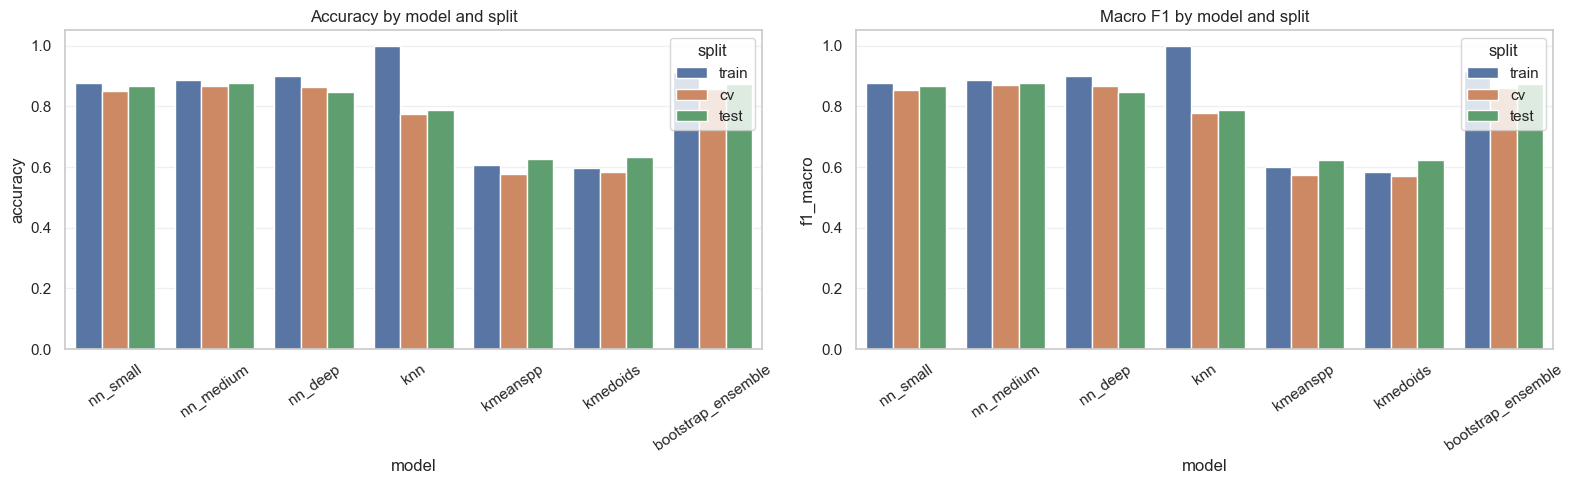

In [9]:
plot_order = model_names + ["bootstrap_ensemble"]

plot_df = all_metrics_df.copy()
plot_df["model"] = pd.Categorical(plot_df["model"], categories=plot_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(
    data=plot_df,
    x="model",
    y="accuracy",
    hue="split",
    ax=axes[0],
    order=plot_order,
)
axes[0].set_title("Accuracy by model and split")
axes[0].set_ylim(0, 1.05)
axes[0].tick_params(axis="x", rotation=35)

sns.barplot(
    data=plot_df,
    x="model",
    y="f1_macro",
    hue="split",
    ax=axes[1],
    order=plot_order,
)
axes[1].set_title("Macro F1 by model and split")
axes[1].set_ylim(0, 1.05)
axes[1].tick_params(axis="x", rotation=35)

for ax in axes:
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()


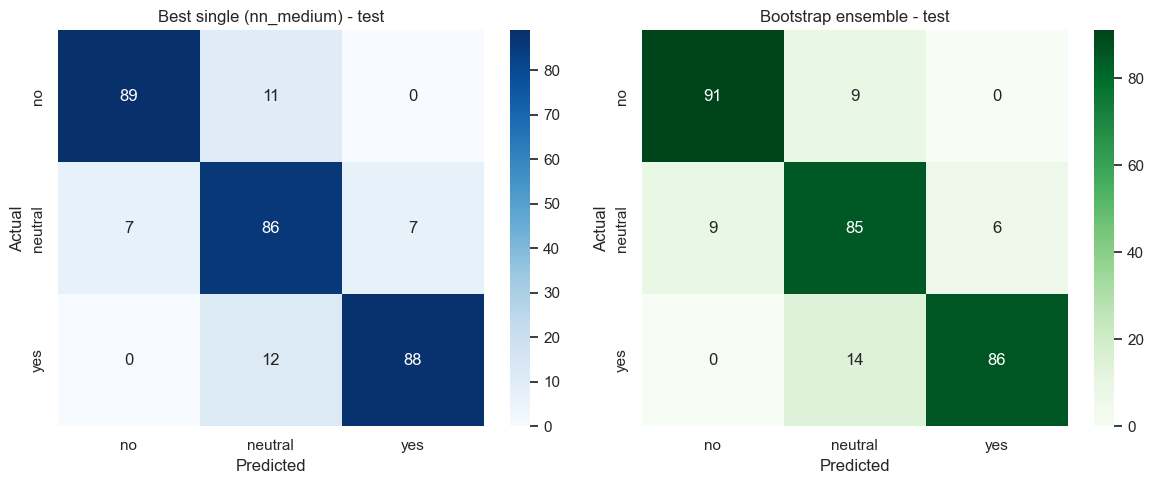

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_single = confusion_matrix(y_test, base_predictions[best_single_by_cv]["test"], labels=class_order)
cm_ens = confusion_matrix(y_test, ensemble_predictions["test"], labels=class_order)

sns.heatmap(
    cm_single,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0],
)
axes[0].set_title(f"Best single ({best_single_by_cv}) - test")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    cm_ens,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1],
)
axes[1].set_title("Bootstrap ensemble - test")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()


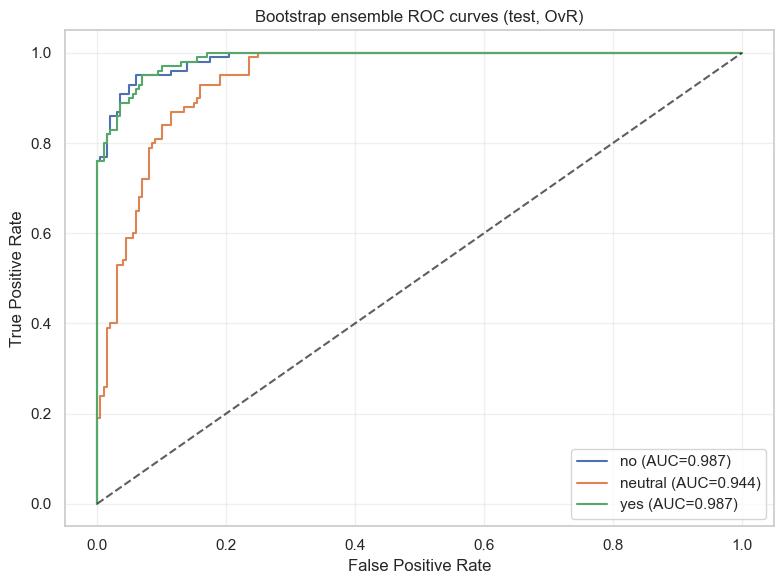

In [11]:
# One-vs-rest ROC curves for the bootstrap ensemble on test split
y_test_bin = label_binarize(y_test, classes=class_order)
proba_ens_test = ensemble_probabilities["test"]

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba_ens_test[:, i])
    auc_i = roc_auc_score(y_test_bin[:, i], proba_ens_test[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc_i:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.7)
plt.title("Bootstrap ensemble ROC curves (test, OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()


C:\Users\91960\AppData\Local\Temp\ipykernel_146296\497263544.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_weight, x="model", y="vote_weight", palette="viridis")


,model,vote_weight
1,nn_medium,0.718202
0,nn_deep,0.714449


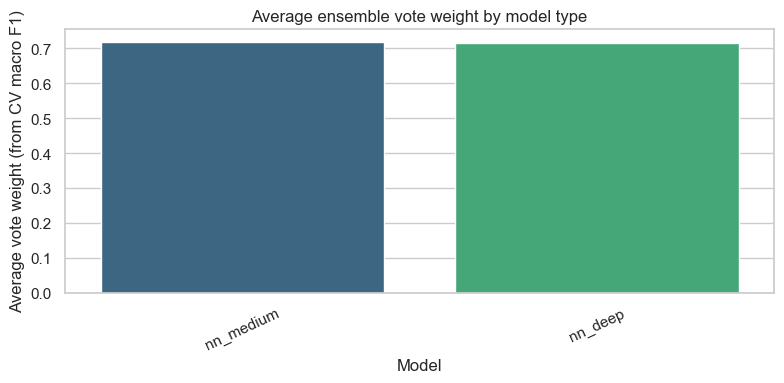

In [12]:
weight_df = pd.DataFrame(weight_records)
mean_weight = (
    weight_df.groupby("model", as_index=False)["vote_weight"]
    .mean()
    .sort_values("vote_weight", ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(data=mean_weight, x="model", y="vote_weight", palette="viridis")
plt.title("Average ensemble vote weight by model type")
plt.xlabel("Model")
plt.ylabel("Average vote weight (from CV macro F1)")
plt.xticks(rotation=25)
plt.tight_layout()

mean_weight


### Notes

- `nn_small` is now a seed-averaged neural model (5 seeds) to reduce variance.
- Scaled dataset (train/cv/test = 3000/400/300) gives more stable CV and test behavior.
- Ensemble uses adaptive top-family selection from CV (`top_k=2`) with a CV quality gate and squared weighting.
- KNN and clustering models are still tracked in single-model comparisons for diversity diagnostics.
